<a href="https://www.kaggle.com/code/yaaangzhou/playground-s3-e21-features-selection-and-tricks?scriptVersionId=141493818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-21] Features Selection and Tricks**

**22 Aug 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Improve a Fixed Model the Data-Centric Way!</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 21</center></p>

***

 
+ **Thanks to the [discussion](https://www.kaggle.com/competitions/playground-series-s3e21/discussion/434376#2409038) and @[chai taifeng](https://www.kaggle.com/chaitaifeng)'s point of view, my previous use of only once train-test splits was very undisciplined and wrong. In the latest version, I changed the evaluation function to 5-fold CV validation.**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Some Insights and Tricks</center>

+ Since we are in need of improving performance on a fixed random forest model, the feature importance of the tree model is very important in selecting features.

+ The four most important features are `O2_1`, `O2_2`, `BOD5_5`, `NO2_2`. In the current results, choosing three features is better than four features.

+ Identifying anomalies in the data is also critical to training the model. There are multiple ways to accomplish this task, one of which is using **Isolation Forest.**

    - **Clip (7, 20)** works much better than **Clip (7, 35)** when using IsolationForest and LocalOutlierFactor.
    
    - There are several algorithms for outlier detection, such as **SGDOneClassSVM** and **LocalOutlierFactor**. In addition, there are some libraries that can do data cleaning, such as **Cleanlab**.


+ Some tricks from Public Kernal:

    - **Remove the data with id 2365**. This trick comes from this [Notebook](https://www.kaggle.com/code/docxian/ps-s3-e21-data-centric-oxygen-prediction/notebook#Data-Adjustments) from [CHRIS X](https://www.kaggle.com/docxian). It brings about a 0.02 MSE improvement.
    
    - Cutoff on target with **Botcutoff set to 7** and **Topcutoff set to 35**. This trick comes from this [Notebook](https://www.kaggle.com/code/achusanjeev/best-score-simple-feature-importance-and-outliers) from [Oppenheimer](https://www.kaggle.com/achusanjeev). It brings about a 0.02 MSE improvement, too.
       
    - The use of **SGDOneClassSVM** comes from this [notebook](https://www.kaggle.com/code/warcoder/lb-1-32253-lof-svm-iforest-cleanlab) by [CHIRAG CHAUHAN](https://www.kaggle.com/warcoder).
    
    - The use of **Cleanlab** comes from this [notebook](https://www.kaggle.com/code/dilgekarakas/cleanlab-finding-noisy-data) by [Dilge Karakas](https://www.kaggle.com/dilgekarakas).
    
    - Set to 0 for all feature traversals to see if there is a reduction in the model's MSE. This feature selection method, comes from this [Notebook](https://www.kaggle.com/code/patrick0302/remove-features-by-setting-zeros-0) by [CHUN FU](https://www.kaggle.com/patrick0302).




# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>

| Version | Description | Public Score |
|---------|-------------|-----------------|
| Version 8 | Add SVM and Cleanlab |1.32259  |
| Version 7 | Add LocalOutlierFactor | 1.3282 |
| Version 6 | Add One more Feature | 1.34248 |
| Version 5 | Add Isolation Forest | 1.34878 |
| Version 4 | Remove id 2365 | 1.36884 |
| Version 3 | Set cutoff to 7-35 | 1.38504 |
| Version 2 | Auto Set Zero | MAE 0.78263 | 
| Version 1 | EDA and Baseline | MAE 0.79226 | 

<a id="0"></a>
# <b> 0. Imports </b>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

<a id="1"></a>
# <b> 1. Load data </b>

In [3]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')
df = submission.copy()

submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


<a id="2"></a>
# <b> 2. Basic EDA </b>

In [4]:
submission.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
id,3500.000000,1749.500000,1010.507298,0.000000,874.750000,1749.500000,2624.250000,3499.000000
target,3500.000000,8.473834,1.885712,1.300000,7.470000,8.280000,9.110000,65.930000
O2_1,3500.000000,8.216993,3.040743,0.000000,7.100000,7.890000,9.100000,46.950000
O2_2,3500.000000,9.291581,6.817822,0.000000,7.300000,8.300000,8.700000,65.950000
O2_3,3500.000000,9.633064,1.439039,4.900000,8.770000,9.500000,9.545000,16.900000
O2_4,3500.000000,8.065733,1.463881,2.300000,6.830000,7.980000,9.265000,21.800000
O2_5,3500.000000,5.671581,2.721399,0.200000,4.550000,5.800000,7.015000,59.400000
O2_6,3500.000000,9.461363,1.140365,0.000000,8.980000,9.430000,10.070000,40.190000
O2_7,3500.000000,6.547433,1.663266,0.000000,5.877500,6.430000,7.150000,15.900000
NH4_1,3500.000000,0.340525,0.284751,0.020000,0.214500,0.247000,0.370000,4.200000


In [5]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(submission).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
id,int64,0,0.000000,3500,3500,0.000000,0.000000,3499.000000,1749.500000
target,float64,0,0.000000,462,3500,10.460854,1.300000,65.930000,8.473834
O2_1,float64,0,0.000000,329,3500,7.753354,0.000000,46.950000,8.216993
O2_2,float64,0,0.000000,258,3500,4.314217,0.000000,65.950000,9.291581
O2_3,float64,0,0.000000,235,3500,1.254857,4.900000,16.900000,9.633064
O2_4,float64,0,0.000000,241,3500,0.782568,2.300000,21.800000,8.065733
O2_5,float64,0,0.000000,317,3500,3.740421,0.200000,59.400000,5.671581
O2_6,float64,0,0.000000,238,3500,5.246618,0.000000,40.190000,9.461363
O2_7,float64,0,0.000000,303,3500,0.285303,0.000000,15.900000,6.547433
NH4_1,float64,0,0.000000,152,3500,3.237432,0.020000,4.200000,0.340525


In [6]:
target = 'target'
num_var = submission.columns.drop(['target','id'])

**Let's take a look at the distribution of different features.**

<Figure size 1000x800 with 0 Axes>

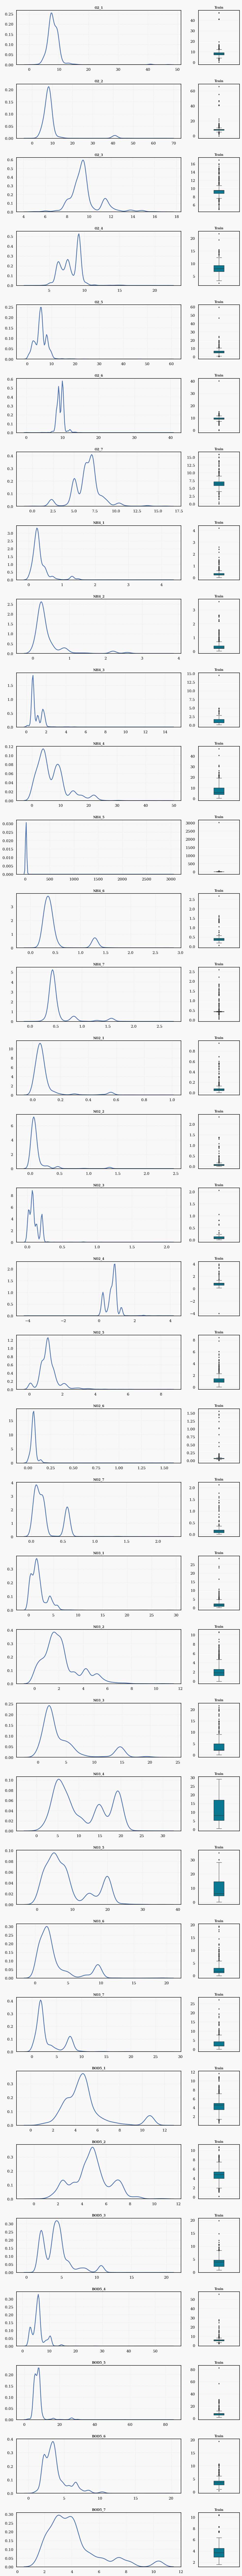

In [7]:
plt.figure(figsize=(10, 8));
fig, axes = plt.subplots(len(num_var), 2 ,figsize=(10, len(num_var) * 3), gridspec_kw={'width_ratios': [4, 1]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = submission, x = col, ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');

    ax = axes[i,1];
    sns.boxplot(data = submission, y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();

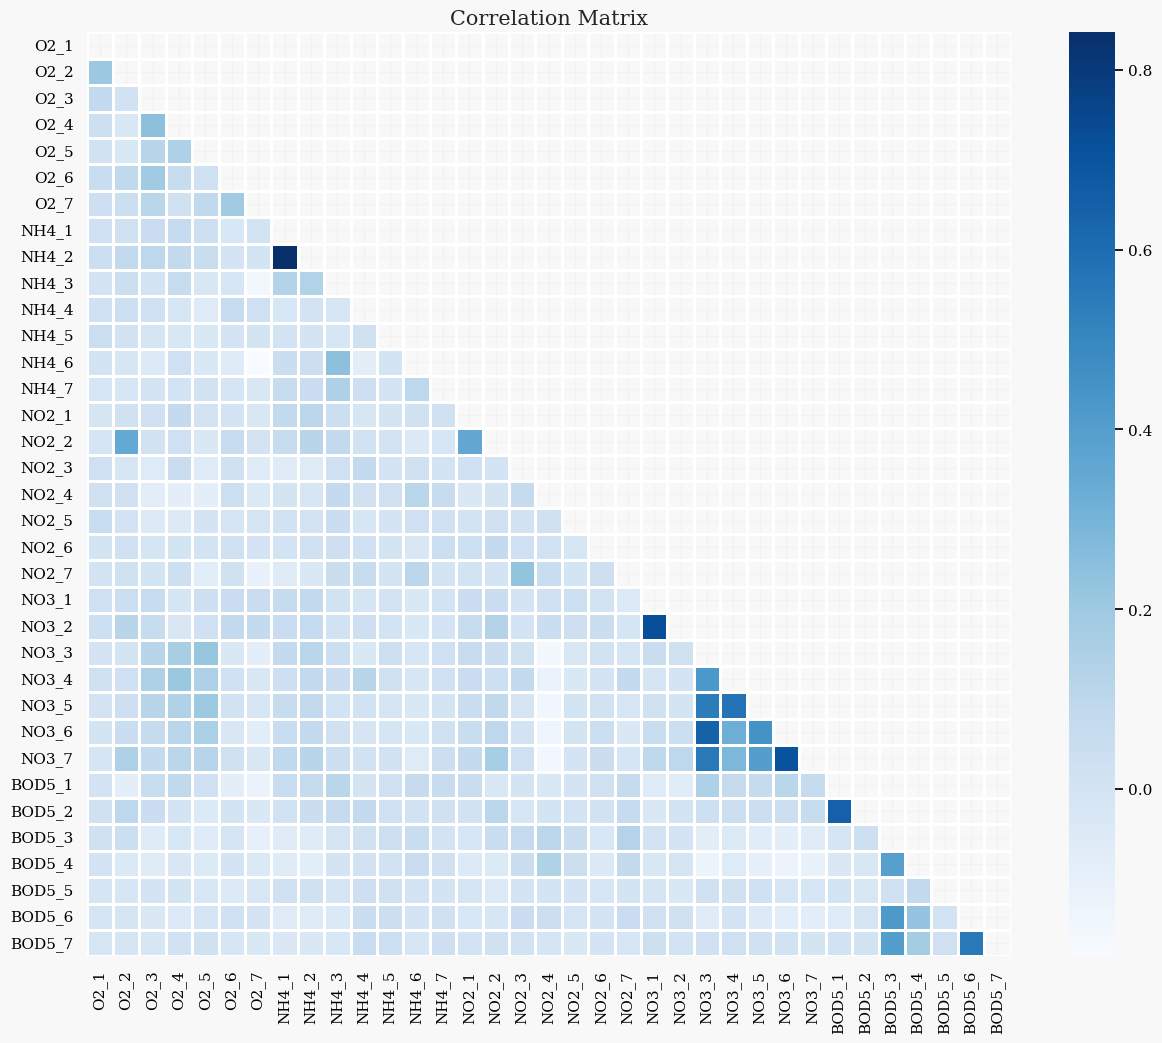

In [8]:
corr_matrix = submission[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

<a id="3"></a>
# <b> 3. Baseline Model</b>

In [9]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

mse_results = pd.DataFrame(columns=['Selected_Features', 'MSE'])

def evaluation(df, select_features, note):
    global mse_results
    
    X = df[select_features]
    Y = df[target]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        rf.fit(X_train, y_train)
        y_hat = rf.predict(X_test) 
        mse = mean_squared_error(y_test, y_hat)
        mse_scores.append(mse)
    
    average_mse = np.mean(mse_scores)
    mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)
    
    print('====================================')
    print(note)
    print("Average MSE:", average_mse)
    print('====================================')


In [10]:
# baseline evaluation

evaluation(df=submission,select_features=num_var,note='Baseline')

Baseline
Average MSE: 2.3171538130551967


**The MAE of the Baseline model reached 1.300, let me try to see if I can reduce it.**

<a id="4"></a>
# <b> 4. Features Selection</b>

## VIF calculation

The method of filtering features by VIF was abandoned in Version 6 because it selected features that did not perform as well as the importance of the features provided by the tree model itself.

I've kept the code here for those who need it.

In [11]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_results = calculate_vif(submission[num_var])
print(vif_results)

   Feature        VIF
0     O2_1   8.840503
1     O2_2   3.697835
2     O2_3  48.340716
3     O2_4  33.434847
4     O2_5   5.911990
5     O2_6  58.198607
6     O2_7  18.011732
7    NH4_1   8.490727
8    NH4_2   6.343775
9    NH4_3   4.575890
10   NH4_4   2.971221
11   NH4_5   1.094900
12   NH4_6   3.633986
13   NH4_7   4.677865
14   NO2_1   1.897085
15   NO2_2   1.884845
16   NO2_3   2.591047
17   NO2_4   5.601847
18   NO2_5   4.503123
19   NO2_6   1.768148
20   NO2_7   2.423107
21   NO3_1   4.946205
22   NO3_2   6.833076
23   NO3_3   4.362984
24   NO3_4   7.051944
25   NO3_5   5.298075
26   NO3_6   5.158091
27   NO3_7   5.448053
28  BOD5_1  13.144511
29  BOD5_2  19.394173
30  BOD5_3   7.756715
31  BOD5_4   7.759643
32  BOD5_5   5.354107
33  BOD5_6   9.447174
34  BOD5_7   8.772270


Generally speaking, a VIF value greater than 10 can be considered as a possible serious collinearity. Therefore, I consider these variables to be zeroed.

In [12]:
vif15_features = vif_results[vif_results['VIF']<15]['Feature'].tolist() # VIF values below 15.
vif10_features = vif_results[vif_results['VIF']<10]['Feature'].tolist() # VIF values below 10.
vif5_features = vif_results[vif_results['VIF']<5]['Feature'].tolist() # VIF values below 5.

In [13]:
evaluation(df=submission,select_features=vif5_features,note='VIF < 5')
evaluation(df=submission,select_features=vif10_features,note='VIF < 10')
evaluation(df=submission,select_features=vif15_features,note='VIF < 15')

VIF < 5
Average MSE: 2.6956695707926768
VIF < 10
Average MSE: 2.318720620538807
VIF < 15
Average MSE: 2.320769527332762


## Feature Importance

In [14]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

In [15]:
rf.fit(submission[num_var],submission[target])

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [16]:
f_imp_df = pd.DataFrame({'feature': num_var, 'imp': rf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)

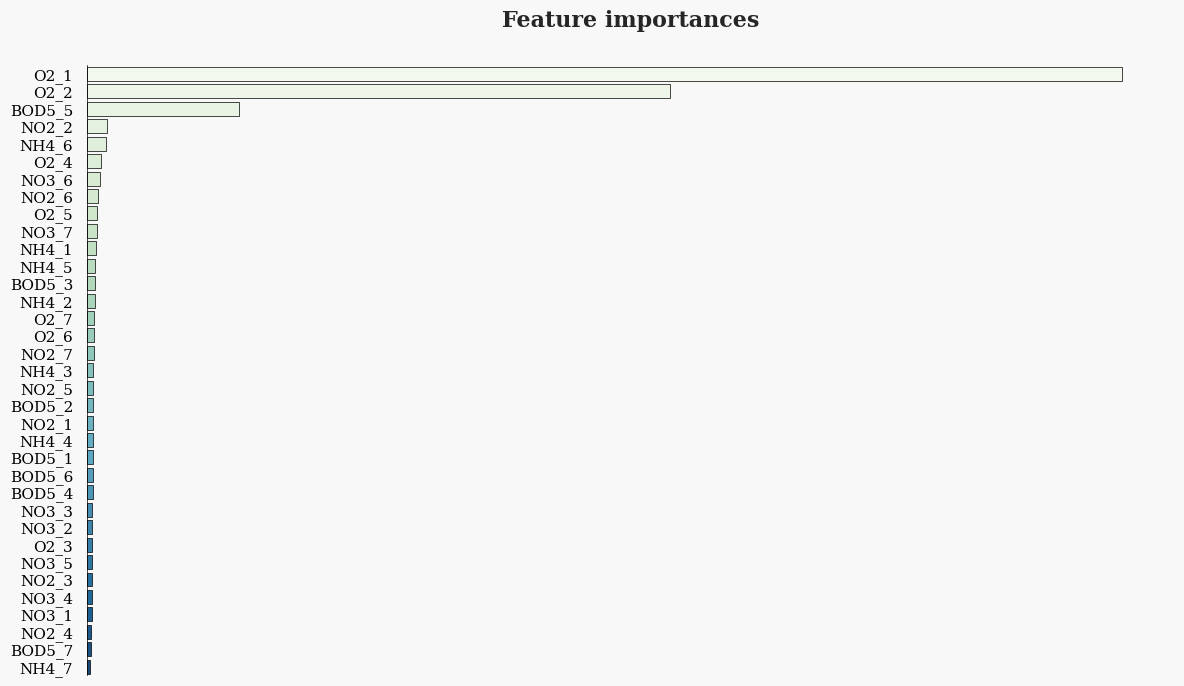

In [17]:
f_importance_plot(f_imp_df)

From the results, there are four features that outperform. We will keep them.

In [18]:
top3rf_features = f_imp_df.head(3).feature.to_list()
top4rf_features = f_imp_df.head(4).feature.to_list()

evaluation(df=submission,select_features=top3rf_features,note='Top 3 Features')
evaluation(df=submission,select_features=top4rf_features,note='Top 4 Features')

Top 3 Features
Average MSE: 2.315712521542403
Top 4 Features
Average MSE: 2.2077474392050016


<a id="5"></a>
# <b> 5. Data Preprocessing</b>

## Trick

In [19]:
submission = submission[submission['id'] != 2365]

evaluation(df=submission,select_features=top4rf_features,note='Trick + Top 4 Features')
evaluation(df=submission,select_features=top3rf_features,note='Trick + Top 3 Features')

Trick + Top 4 Features
Average MSE: 2.1561263934512978
Trick + Top 3 Features
Average MSE: 2.2537476926784636


## Search Best Cutoff

**[7, 20]** and **[7, 35]** are proved to be good cutoff points. After Version 7, I skipped its calculation process, but still kept the code for anyone who needs to see it. 

The conclusions for clips come from this [notebook](https://www.kaggle.com/code/achusanjeev/best-score-simple-feature-importance-and-outliers).


In [20]:
def search_best_cutoff(df,bot_cutoff,top_cutoff):
    X = df.drop(target,axis=1)
    Y = df[target].clip(bot_cutoff,top_cutoff)
    
    for column in X.columns:
        if column not in ['O2_1','O2_2','BOD5_5']:
            X[column] = 0
        
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=1000,max_depth=7,n_jobs=-1,random_state=42)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test) 
    mse =  mean_squared_error(y_test, y_hat)
    return mse
    print("MSE:", mse)

In [21]:
#min_error = 50.0
#bot_cutoffs = [5,5.5,6,6.5,7,7.5,8]
#top_cutoffs = [15,20,25,30,35,40,45,50,55,60]
#iteration = 1
#for bot_cutoff in bot_cutoffs:
#    for top_cutoff in top_cutoffs:
#        mse = search_best_cutoff(submission,bot_cutoff,top_cutoff)
#        if mse < min_error:
#            min_error = mse
#            min_bot_cutoff = bot_cutoff
#            min_top_cutoff = top_cutoff
#            print(f'min_cutoff: {min_bot_cutoff},{min_top_cutoff}, mse:{min_error}')

#        print(f'Iteration {iteration} of {len(bot_cutoffs)*len(top_cutoffs)}')
#        iteration +=1

In [22]:
# Clip outliner
submission7_20 = submission.copy()
submission7_20.target = submission7_20.target.clip(7, 20)

submission7_35 = submission.copy()
submission7_35.target = submission7_35.target.clip(7, 35)

In [23]:
print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20,select_features=top4rf_features,note='Clip(7,20) + Top 4 Features')
evaluation(df=submission7_20,select_features=top3rf_features,note='Clip(7,20) + Top 3 Features')

print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35,select_features=top4rf_features,note='Clip(7,35) + Top 4 Features')
evaluation(df=submission7_35,select_features=top3rf_features,note='Clip(7,35) + Top 3 Features')

=============Clip(7_20)==============
Clip(7,20) + Top 4 Features
Average MSE: 0.9163656729431462
Clip(7,20) + Top 3 Features
Average MSE: 0.9553051540520208
=============Clip(7_35)==============
Clip(7,35) + Top 4 Features
Average MSE: 1.203084176992172
Clip(7,35) + Top 3 Features
Average MSE: 1.2547979848252255


## SGDOneClassSVM

In [24]:
# Clip 7_20 + SGD
submission7_20_sgd = submission7_20.copy()
clf = SGDOneClassSVM(nu=0.55).fit(submission7_20_sgd.drop(['id'],axis=1))

# Drop outliers
submission7_20_sgd.drop(np.array(np.where(clf.predict(submission7_20_sgd.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission7_20_sgd = submission7_20_sgd.reset_index(drop=True)


# Clip 7_35 + SGD
submission7_35_sgd = submission7_35.copy()
clf = SGDOneClassSVM(nu=0.55).fit(submission7_35_sgd.drop(['id'],axis=1))

# Drop outliers
submission7_35_sgd.drop(np.array(np.where(clf.predict(submission7_35_sgd.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission7_35_sgd = submission7_35_sgd.reset_index(drop=True)

In [25]:
print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_sgd,select_features=top4rf_features,note='Clip(7,20) + SGD + Top 4 Features')
evaluation(df=submission7_20_sgd,select_features=top3rf_features,note='Clip(7,20) + SGD + Top 3 Features')

print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_sgd,select_features=top4rf_features,note='Clip(7,35) + SGD + Top 4 Features')
evaluation(df=submission7_35_sgd,select_features=top3rf_features,note='Clip(7,35) + SGD + Top 3 Features')

=============Clip(7_20)==============
Clip(7,20) + SGD + Top 4 Features
Average MSE: 1.0020496263951921
Clip(7,20) + SGD + Top 3 Features
Average MSE: 1.0483853444522837
=============Clip(7_35)==============
Clip(7,35) + SGD + Top 4 Features
Average MSE: 1.2066984248552592
Clip(7,35) + SGD + Top 3 Features
Average MSE: 1.270729087286981


## IsolationForest

The idea comes from this [notebook](https://www.kaggle.com/code/act18l/added-isolationforest-very-simple-approach). @ SPIRITMILK

The Isolation Forest algorithm performs anomaly detection on the data.

In [26]:
# Clip 7_20 + IF
submission7_20_if = submission7_20.copy()
clf = IsolationForest(random_state=0).fit(submission7_20_if.drop(['id'],axis=1))
submission7_20_if.drop(np.array(np.where(clf.predict(submission7_20_if.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)

In [27]:
# Clip 7_35 + IF
submission7_35_if = submission7_35.copy()
clf = IsolationForest(random_state=0).fit(submission7_35_if.drop(['id'],axis=1))
submission7_35_if.drop(np.array(np.where(clf.predict(submission7_35_if.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)

In [28]:
print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_if,select_features=top4rf_features,note='Clip(7,20) + IF + Top 4 Features')
evaluation(df=submission7_20_if,select_features=top3rf_features,note='Clip(7,20) + IF + Top 3 Features')

print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_if,select_features=top4rf_features,note='Clip(7,35) + IF + Top 4 Features')
evaluation(df=submission7_35_if,select_features=top3rf_features,note='Clip(7,35) + IF + Top 3 Features')

=============Clip(7_20)==============
Clip(7,20) + IF + Top 4 Features
Average MSE: 0.9644636879589907
Clip(7,20) + IF + Top 3 Features
Average MSE: 0.9733439833571852
=============Clip(7_35)==============
Clip(7,35) + IF + Top 4 Features
Average MSE: 1.354607550435106
Clip(7,35) + IF + Top 3 Features
Average MSE: 1.3575027944180225


## LocalOutlierFactor

The LOF algorithm identifies outliers by comparing the local density of each data point. 

The idea comes from this [notebook](https://www.kaggle.com/code/satyaprakashshukl/local-outlier-factor-solation-quality-infer). @ SATYA

In [29]:
# Clip 7_20 + LOF
submission7_20_lof = submission7_20.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_predictions = lof.fit_predict(submission7_20_lof[num_var])
outliers_indices = np.where(outlier_predictions == -1)[0]
submission7_20_lof.drop(outliers_indices, axis=0, inplace=True)

In [30]:
# Clip 7_35 + LOF
submission7_35_lof = submission7_35.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_predictions = lof.fit_predict(submission7_35_lof[num_var])
outliers_indices = np.where(outlier_predictions == -1)[0]
submission7_35_lof.drop(outliers_indices, axis=0, inplace=True)

In [31]:
print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_lof,select_features=top4rf_features,note='Clip(7,20) + LOF + Top 4 Features')
evaluation(df=submission7_20_lof,select_features=top3rf_features,note='Clip(7,20) + LOF + Top 3 Features')

print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_lof,select_features=top4rf_features,note='Clip(7,35) + LOF + Top 4 Features')
evaluation(df=submission7_35_lof,select_features=top3rf_features,note='Clip(7,35) + LOF + Top 3 Features')

=============Clip(7_20)==============
Clip(7,20) + LOF + Top 4 Features
Average MSE: 0.9546300406453467
Clip(7,20) + LOF + Top 3 Features
Average MSE: 0.9694545482722244
=============Clip(7_35)==============
Clip(7,35) + LOF + Top 4 Features
Average MSE: 1.1129268092739926
Clip(7,35) + LOF + Top 3 Features
Average MSE: 1.1327911502763324


In [32]:
mse_results.sort_values(by='MSE')

,Selected_Features,MSE
8,"Clip(7,20) + Top 4 Features",0.916366
20,"Clip(7,20) + LOF + Top 4 Features",0.954630
9,"Clip(7,20) + Top 3 Features",0.955305
16,"Clip(7,20) + IF + Top 4 Features",0.964464
21,"Clip(7,20) + LOF + Top 3 Features",0.969455
17,"Clip(7,20) + IF + Top 3 Features",0.973344
12,"Clip(7,20) + SGD + Top 4 Features",1.002050
13,"Clip(7,20) + SGD + Top 3 Features",1.048385
22,"Clip(7,35) + LOF + Top 4 Features",1.112927
23,"Clip(7,35) + LOF + Top 3 Features",1.132791


## Combination of All solutions

In [33]:
df = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

# df = df[df.id != 2365]
df.target = df.target.clip(7, 20)

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(df.drop(['id'],axis=1))
df.drop(np.array(np.where(clf.predict(df.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
df = df.reset_index(drop=True)

# IsolationForest
lf = IsolationForest(random_state=0).fit(df.drop(['id'],axis=1))
df.drop(np.array(np.where(lf.predict(df.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
df = df.reset_index(drop=True)

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
predictions = lof.fit_predict(df[num_var])
df = df.drop(index=np.where(predictions == -1)[0])
df.reset_index(drop=True, inplace=True)

# Tricks from https://www.kaggle.com/code/warcoder/lb-1-32253-lof-svm-iforest-cleanlab
lowest_quality_labels = [2365, 1089, 1936, 1680, 211]
df.drop(list(lowest_quality_labels),inplace=True)

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0

<a id="6"></a>
# <b> 6. Submission </b>

In [34]:
def set_zero(df,col_to_keep):
    col_to_keep.append(target) # Keep target in dataset
    df_sub = df.copy()
    for i in df_sub.columns:
        if i not in col_to_keep:
            df_sub[i] = 0
    return df_sub

In [35]:
# Combination + Top 3 Features
df.to_csv('submission.csv', index=False)

# Clip(7,35) + LOF + Top 3 Features
submission7_35_lof_3 = set_zero(submission7_35_lof,top3rf_features)
submission7_35_lof_3.to_csv('submission7_35_lof_3.csv', index=False)

